In [158]:
import tensorflow as tf
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os as os
import fetchyc
import collections
import kerastuner as kt
from tensorflow.keras.optimizers import Adam

#!pip install -q requests
import requests
import json

# 2. Fetch and expand to new terms

In [186]:
class NelsonSiegelLayer(tf.keras.layers.Layer):
    def __init__(self, thau0 = 64.0, eps = 0.00001):
        super(NelsonSiegelLayer, self).__init__()
        self.eps = eps
        self.thau = self.add_weight(name = "Thau", shape = (), 
                                     initializer = tf.keras.initializers.Constant(thau0),
                                     #constraint = tf.keras.constraints.NonNeg(),
                                     trainable = True)
        self.alpha0 = self.add_weight(name = "Alpha0", shape = (), 
                                     initializer = tf.keras.initializers.RandomUniform(0.0, 1.0),
                                     constraint = tf.keras.constraints.NonNeg(),
                                     trainable = True)
        self.alpha1 = self.add_weight(name = "Alpha1", shape = (), 
                                     initializer = tf.keras.initializers.RandomUniform(0.0, 1.0),
                                     constraint = tf.keras.constraints.NonNeg(),
                                     trainable = True)
        self.alpha2 = self.add_weight(name = "Alpha2", shape = (), 
                                     initializer = "random_normal",                           
                                     trainable = True)
        #self.bias = self.add_weight(name = "Bias", shape = (), trainable = True)
        
    def reassignValues(self, thau0 = 64.0):
        self.thau.assign(thau0)
        self.alpha0.assign(tf.random.uniform(shape=(), minval = 0.0, maxval = 1.0))
        self.alpha1.assign(tf.random.uniform(shape=(), minval = 0.0, maxval = 1.0))
        self.alpha2.assign(tf.random.normal(shape=()))
        
    def call(self, inputs):
        val1 = tf.divide(inputs, self.thau)
        val2 = tf.math.exp(-val1)
        val3 = tf.divide(1.0 - val2, val1)
        eps = self.eps
        return tf.add(tf.math.multiply(self.alpha0 + eps, 1.0 - val3), 
                                       tf.add(tf.math.multiply(self.alpha1 + eps, val3),
                                        tf.math.multiply(self.alpha2, val3 - val2)))

In [211]:
TermMapToMonth = { 'M01' : 1.0, 'M02' : 2.0, 'M03' : 3.0, 'M04' : 4.0, 'M05' : 5.0, 'M06' : 6.0, 'M07' : 7.0, 'M08' : 8.0,
                    'M09' : 9.0, 'M10' : 10.0, 'M11' : 11.0, 
                    'Y01' : 12.0, 'Y02' : 24.0, 'Y03' : 36.0, 'Y04' : 48.0, 'Y05' : 60.0, 'Y06' : 72.0, 'Y07' : 84.0,
                    'Y08' : 96.0, 'Y09' : 108.0, 'Y10' : 120.0, 'Y12' : 144.0, 'Y15' : 180.0, 'Y20' : 240.0,
                    'Y25' : 300.0, 'Y30' : 360.0, 'Y40' : 480.0, 'Y50' : 600.0}

class NelsonSiegelParameters:
    def __init__(self, ww = 13, thauv = [32, 64, 128], lr = 0.1, epochs = 200):
        self.ww = ww
        self.thauv = thauv
        self.nsld = {thau : NelsonSiegelLayer(thau0 = thau) for thau in self.thauv}
        self.lr = lr
        self.epochs = epochs
        self.modelv = [self.__create_model(nsl) for nsl in self.nsld.values()]
        self.histv = None
        self.resdf = pd.DataFrame(columns = ['Date', 'Alpha0', 'Alpha1', 'Alpha2', 'Thau'])
                                  
    def __create_model(self,nsl):
        inputs = tf.keras.Input(shape = ())
        outputs = nsl(inputs)
        model = tf.keras.Model(inputs, outputs)
        model.compile(optimizer=Adam(lr=self.lr), loss="mse")
        return model        
    
    def __train_step(self, x, y):
        for thau,nsl in self.nsld.items():
            nsl.reassignValues(thau)
        self.histv = [model.fit(x, y, epochs = self.epochs, verbose = 0) for model in self.modelv]
        
    def find_parameters(self, filename):
        cv = list(pd.read_csv(filename, nrows = 0).columns)
        rec = [tf.float32] * len(cv)
        rec[cv.index('Date')] = tf.string
        dataset = tf.data.experimental.CsvDataset(filename, rec, header = True).window(self.ww,1,1,True)
        resdict = {key : [] for key in self.resdf.columns}
        i = 0
        for window in dataset:
            mdate, x, y = None, None, None
            for column, component in zip(cv, window):
                if column == 'Date':
                    mdate = list(component.as_numpy_iterator())
                    mdate = mdate[len(mdate) // 2]
                    continue
                _y = np.array(list(component.as_numpy_iterator()))
                _y = _y[_y > -255.0]
                if _y.shape[0] == 0:
                    continue
                _x = np.repeat(TermMapToMonth[column], _y.shape[0])
                if x is None:
                    x, y = (_x, _y)
                    continue
                x = np.concatenate([x, _x])
                y = np.concatenate([y,_y])
            self.__train_step(x,y)
            resdict['Date'] += [mdate] * len(self.thauv)
            print("Window - {}".format(i))
            i += 1
            for val in self.nsld.values():
                resdict['Alpha0'].append(val.alpha0.numpy())
                resdict['Alpha1'].append(val.alpha1.numpy())
                resdict['Alpha2'].append(val.alpha2.numpy())
                resdict['Thau'].append(val.thau.numpy())
        self.resdf = pd.DataFrame(resdict)
        self.resdf['Date'] = self.resdf['Date'].str.decode('utf-8')
        return self.resdf
    
def SaveNSParameters(dirpath, ww = 13, epochs = 200):
    for filename in os.listdir(dirpath):
        filepath = os.path.join(dirpath,filename)
        if os.path.isfile(filepath):
            engine = NelsonSiegelParameters(ww = ww, epochs = epochs)
            df_ext = engine.find_parameters(filepath)
            df_orig = pd.read_csv(filepath, converters = {'Date' : lambda x: pd.to_datetime(x)})
            df = df_orig.merge(df_ext,on = 'Date', sort = True, how = 'outer')
            file_name, file_extension = os.path.splitext(filepath)
            newfilepath = file_name + '_ns' + file_extension
            df.to_csv(newfilepath)


In [212]:
SaveNSParameters('./2/', epochs = 2)

Window - 0
Window - 1
Window - 2
Window - 3
Window - 4
Window - 5
Window - 6
Window - 7
Window - 8
Window - 9
Window - 10
Window - 11
Window - 12
Window - 13
Window - 14
Window - 15
Window - 16
Window - 17
Window - 18
Window - 19
Window - 20
Window - 21
Window - 22
Window - 23
Window - 24
Window - 25
Window - 26
Window - 27
Window - 28
Window - 29
Window - 30
Window - 31
Window - 32
Window - 33
Window - 34
Window - 35
Window - 36
Window - 37
Window - 38
Window - 39
Window - 40
Window - 41
Window - 42
Window - 43
Window - 44
Window - 45
Window - 46
Window - 47
Window - 48
Window - 49
Window - 50
Window - 51


ValueError: You are trying to merge on datetime64[ns] and object columns. If you wish to proceed you should use pd.concat

EU_France_9480
.csv
EU_Germany_12046
.csv
EU_UK_11354
.csv
fetchyc
.py
mhs
.ipynb
NA_US_14640
.csv
proba
.csv
Server
.ipynb
Untitled-Copy1
.ipynb


In [ ]:
start = time.time()
tt = NelsonSiegelParameters(ww=14)
ddf = tt.find_parameters('./proba.csv')
end = time.time()
print(end-start)

In [193]:
ddf

,Date,Alpha0,Alpha1,Alpha2,Thau
0,2020-02-21,2.134947,1.560652,-2.087966,34.810089
1,2020-02-21,2.219409,1.572491,-2.076935,39.230858
2,2020-02-21,3.056587,1.467457,-2.741569,97.971809
3,2020-02-24,2.128917,1.550501,-2.106614,34.089321
4,2020-02-24,2.188201,1.458313,-2.208893,40.377972
...,...,...,...,...,...
148,2020-05-01,1.820199,0.075334,-1.224260,67.354980
149,2020-05-01,2.193424,0.066607,-0.698010,129.611572
150,2020-05-04,1.681195,0.128091,-1.478698,47.856609
151,2020-05-04,1.859323,0.107206,-1.248381,66.934677


In [201]:
tt.modelv[0]

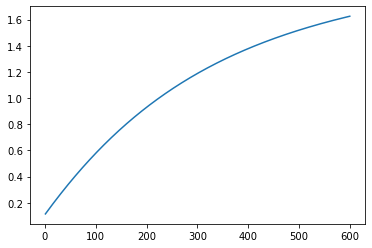

In [208]:
t = np.arange(600).astype('float32') + 1.0
y = tt.modelv[2].predict(t)
plt.plot(t,y)

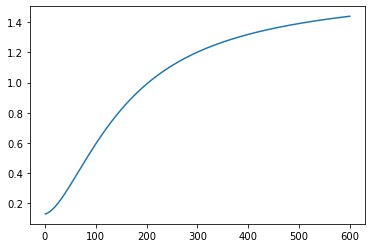

In [170]:
rr = tt.nsld['Thau_32']

In [185]:
rr.weights

[<tf.Variable 'Thau:0' shape=() dtype=float32, numpy=164.0>,
 <tf.Variable 'Alpha0:0' shape=() dtype=float32, numpy=1.9049475>,
 <tf.Variable 'Alpha1:0' shape=() dtype=float32, numpy=0.5884223>,
 <tf.Variable 'Alpha2:0' shape=() dtype=float32, numpy=-1.5314803>]

In [184]:
rr.thau.assign(164.0)
rr.alpha1.assign(tf.random.uniform(shape=(), minval = 0.0, maxval = 1.0))

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.5884223>

In [181]:
rr.thau

<tf.Variable 'Thau:0' shape=() dtype=float32, numpy=164.0>

In [157]:


start = time.time()
print("hello")
end = time.time()
print(end - start)


,Date,Alpha0,Alpha1,Alpha2,Thau
0,1986-01-08,8.154904,7.465635,7.247425,59.262356
1,1986-01-08,7.703991,8.221745,7.484064,119.891510
2,1986-01-09,8.159197,7.469697,7.251604,59.262669
3,1986-01-09,7.708381,8.225805,7.488358,119.876961


In [149]:
pd.to_datetime(ddf['Date'].str.decode('utf-8'))

0   1986-01-08
1   1986-01-08
2   1986-01-09
3   1986-01-09
Name: Date, dtype: datetime64[ns]

In [109]:
pd.DataFrame(columns = ['Date', 'Alpha0', 'Alpha1', 'Alpha2'])

,Date,Alpha0,Alpha1,Alpha2


In [118]:
dd = {'a':5, 'b':8}
list(dd.keys())

['a', 'b']

In [134]:
pd.read_csv('./EU_France_9480.csv', nrows = 2)

,Date,M01,M03,M06,M09,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y15,Y20,Y25,Y30,Y50
0,1986-01-03,-256.0,-256.0,-256.0,-256.0,-256.0,-256.0,-256.0,-256.0,-256.0,-256.0,-256.0,-256.0,-256.0,9.993,-256.0,-256.0,-256.0,-256.0,-256.0
1,1986-01-06,-256.0,-256.0,-256.0,-256.0,-256.0,-256.0,-256.0,-256.0,-256.0,-256.0,-256.0,-256.0,-256.0,9.997,-256.0,-256.0,-256.0,-256.0,-256.0


In [ ]:
#!pip install -q -U keras-tuner

In [101]:
TermMapToMonth = { 'M01' : 1.0, 'M02' : 2.0, 'M03' : 3.0, 'M04' : 4.0, 'M05' : 5.0, 'M06' : 6.0, 'M07' : 7.0, 'M08' : 8.0,
                    'M09' : 9.0, 'M10' : 10.0, 'M11' : 11.0, 
                    'Y01' : 12.0, 'Y02' : 24.0, 'Y03' : 36.0, 'Y04' : 48.0, 'Y05' : 60.0, 'Y06' : 72.0, 'Y07' : 84.0,
                    'Y08' : 96.0, 'Y09' : 108.0, 'Y10' : 120.0, 'Y12' : 144.0, 'Y15' : 180.0, 'Y20' : 240.0,
                    'Y25' : 300.0, 'Y30' : 360.0, 'Y40' : 480.0, 'Y50' : 600.0}

RecordDefaults = [tf.string] + [tf.float32] * 19
dataset = tf.data.experimental.CsvDataset('./EU_France_9480.csv', RecordDefaults,header = True).window(27,1,1,True).take(1)
df = pd.read_csv('./EU_France_9480.csv', nrows = 0)
cv = list(df.columns)
for window in dataset:
    mdate, x, y = None, None, None
    for column, component in zip(cv, window):
        if column == 'Date':
            mdate = list(component.as_numpy_iterator())
            mdate = mdate[len(mdate) // 2]
            continue
        _y = np.array(list(component.as_numpy_iterator()))
        _y = _y[_y > -255.0]
        if _y.shape[0] > 0:
            _x = np.repeat(TermMapToMonth[column], _y.shape[0])
            if x is None:
                x, y = _x, _y
                continue
            x = np.concatenate([x, _x])
            y = np.concatenate([y,_y])
    print(mdate)
    print(x)
    print(y)

b'1986-01-22'
[120. 120. 120. 120. 120. 120. 120. 120. 120. 120. 120. 120. 120. 120.
 120. 120. 120. 120. 120. 120. 120. 120. 120. 120. 120. 120. 120.]
[ 9.993  9.997 10.002 10.006 10.018 10.023 10.027 10.031 10.035 10.048
 10.052 10.056 10.061 10.065 10.078 10.082 10.086 10.091 10.095 10.103
 10.103 10.093 10.093 10.136 10.165 10.144 10.073]


In [ ]:
for window in dataset:
    def to_numpy(ds):
        return list(ds.as_numpy_iterator())
    print(tuple(to_numpy(component) for component in window))

In [ ]:
dataset = tf.data.experimental.make_csv_dataset('./EU_France_9480.csv',batch_size = 360, shuffle = False)
rr = None
for it in dataset.map(lambda x: fetchyc.mapelement(x)):
    d = it['Date'].numpy()
    if d > b'2010-01-01':
        rr = it
        break

# 1.Fetch and combine all available data into single data frame table

In [ ]:
NSL = NelsonSiegelLayer(thau0 = 64)
inputs = tf.keras.Input(shape = ())
outputs = NSL(inputs)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.1), loss="mse")
hist = model.fit(rr['XY'][1], rr['XY'][0], epochs = 256, verbose = 0)
print(model.evaluate(rr['XY'][1], rr['XY'][0], verbose = 0))
print(NSL.thau)

In [ ]:
model.predict(np.array([360.0]))

In [ ]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = "./models"
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')

In [ ]:
mm = tf.keras.models.load_model(export_path)

In [ ]:
mm.predict(np.array([360.0]))

In [ ]:
!saved_model_cli show --dir {export_path} --all

In [ ]:
!docker run -p 8511:8511 \
  --mount type=bind,source="C:\\Users\\PLDD\\Practice\\GitHub\\Python\\MHS\\models",target="\\models\\my_model" \
  -e MODEL_NAME=my_model -t tensorflow/serving

In [ ]:
"C:\\Users\\PLDD\\Practice\\GitHub\\Python\\MHS\\models"

In [ ]:
!docker run --help

In [ ]:
time_seq = np.arange(600)
data = json.dumps({"signature_name": "serving_default", "instances": time_seq.tolist()})
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/my_model:predict', data=data, headers=headers)
y = json.loads(json_response.text)['predictions']
plt.plot(x,y)

In [22]:
dataset = tf.data.Dataset.range(7).window(3, 1, 1, True)
for window in dataset.take(2):
    print(list(window.as_numpy_iterator()))

[0, 1, 2]
[1, 2, 3]


In [ ]:
plt.plot(hist.epoch, np.log(hist.history['loss']))

In [ ]:
time_seq = np.arange(600)
x = time_seq[:600]
y = model.predict(x)
plt.plot(x,y)

In [ ]:
rr['XY']

In [ ]:
tunning_epoch_cnt = 256
def model_builder(hp): 
    
    inputs = tf.keras.Input(shape = ())
    hp_thau = hp.Float('thau0',min_value = 1.0, max_value = 120.0, default=64.0,
                    step=10.0)
    outputs = NelsonSiegelLayer(thau0 = hp_thau)(inputs)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse")
    return model

tuner = kt.Hyperband(model_builder,
                     objective = 'loss', 
                     max_epochs = tunning_epoch_cnt,
                     factor = 2,
                     directory = 'keras_tuning', # throw exception when either capital letters or numbers are in name of directory
                     project_name = 'some') # throw exception when either capital letters or numbers are in name of directory

tuner.search(rr['XY'][1], rr['XY'][0], epochs = tunning_epoch_cnt, verbose = 0)
tuner.results_summary()

In [ ]:
thauV = np.arange(1.0, 120.0, 10.)
realV = []
lossV = []

In [ ]:
for thau in thauV:
    NSL = NelsonSiegelLayer(thau0 = thau)
    inputs = tf.keras.Input(shape = ())
    outputs = NSL(inputs)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse")
    model.fit(rr['XY'][1], rr['XY'][0], epochs = 1024, verbose = 0)
    lossV.append(model.evaluate(rr['XY'][1], rr['XY'][0], verbose = 0))
    realV.append(NSL.thau)

In [ ]:
srcdir = r'.\data\raw\YC'
destdir = './'
fetchyc.FirstConversion()

In [ ]:
def mapelement(table):
    valpairs = None
    for key, x in TermMapToMonth.items():
        if key in not table:
            continue
        xy = table[key][table[key] > 256.0]
        if table[key].dtype == tf.string:
            print(table[key])
            #xy = tf.strings.to_number(table[key][table[key] != b''], out_type=tf.dtypes.float32)
            xy = tf.strings.to_number(table[key], out_type=tf.dtypes.float32)
            print(xy)
            print(table[key])
        if xy.shape[0] is not None:
            xy = tf.stack([xy, tf.repeat(x,xy.shape[0])])
            if valpairs is None:
                valpairs = xy
            else:
                valpairs = tf.concat([valpairs,xy], axis = 1)       
    m = table['Date'].shape[0] // 2
    return {'Date' : table['Date'][m], 'XY' : valpairs}

@tf.function
def mapelement1(table):
    obss = tf.convert_to_tensor(np.array([[-256.0], [-256.0]]), dtype = tf.float32)
    tt = 'M01'
    x = TermMapToMonth[tt]
    xy = tf.convert_to_tensor(table[tt])
    print(xy)
    lx = xy > -255.0
    xy = tf.boolean_mask(xy, lx)
    #print(xy)
    #print(xy.numpy())
    xy = tf.stack([xy, tf.repeat(x,xy.shape[0])])
    obss = tf.concat([obss,xy], axis = 1) 
    print(obss)
    lx = obss[0] > -255.0
    print(lx)
    obss = tf.boolean_mask(obss, lx, axis = 1)
    median = table['Date'].shape[0] // 2
    return {'Date' : table['Date'][median], 'XY' : xy}

In [ ]:
t = np.linspace(6.5, 20.0, 5)
#t = [6.8]
b0 = 5
b1 = -1
b2 = 3
b0, b1, b2 = (0.0466, -0.0429, 0.0712)
for x in np.linspace(0.0, 100.0, 10):
    b0 = np.linspace(0.0, 100.0, 1000)
    m = 6.5
    y = np.exp(b0) + ((b1 + b2) * (1.0 - np.exp(-x/m))/(x/m)) - b2 * np.exp(-x/m)
    plt.plot(b0, y)
plt.show()

In [ ]:
    
b0 = np.linspace(-100, 100.0, 100)
b2 = 3.14
for b1 in np.linspace(0.0, 17.5, 10):
    y = (np.exp(b0) + np.exp(b1 - b0) - b2)**2
    plt.plot(b0, y)
plt.show()